To setup the environment run the following commands on kaggle

In [1]:
!cp /kaggle/input/a3-2-1/A3_Part2/environment.yml /kaggle/working/
!cp /kaggle/input/a3-2-1/A3_Part2/install.sh /kaggle/working/


!bash install.sh

Installing dependencies from environment.yml using pip...
Environment setup completed successfully!


Run your .py file on CLI using the following command

```bash
# Running code for training. save the model in the same directory with name "vae.pth"
# Save the GMM parameters in the same folder. You can use pickle to save the parameters. 
!python vae.py path_to_train_dataset path_to_val_dataset train vae.pth gmm_params.pkl



# Running code for vae reconstruction.
# This should save the reconstruced images in numpy format. see below for more details.
!python vae.py path_to_test_dataset_recon test_reconstruction vae.pth

#Running code for class prediction during testing
!python vae.py path_to_test_dataset test_classifier vae.pth gmm_params.pkl
```

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



### Data Preparation and Loading
- **Data Loading:**
  - Load images as PyTorch tensors.
  - Implement a custom `Dataset` class for easy data handling.
- **Data Transformation & Preprocessing:**
  - Padding, cropping, and resizing to standardize image dimensions if needed.
  - Apply transforms like grayscale normalization, resizing, and scaling between [0, 1].

### Exploratory Data Analysis (EDA)
- Visualize a few images from each class (1, 4, 8) for reference.
- Calculate the mean and variance of pixel intensities across the dataset.
- Plot pixel intensity histograms and class distributions to check for imbalances.

---

### Model Architectures & Variants
- **Encoder-Decoder Architectures to Try:**
  - **Dense Layers Only**: Simple MLP-based VAE for both encoder and decoder.
  - **CNN-Based Encoder, Dense Decoder**: CNN layers in the encoder to capture spatial patterns, with dense layers for the decoder.
  - **Hybrid Models**: Experiment with CNN-based encoder and decoder for richer representation.
  - **Residual and Skip Connections**: Add residual connections in the encoder to improve information flow.
  
- **Scaling & Regularization Techniques:**
  - Batch Normalization and Layer Normalization
  - Experiment with Dropout, DropBlock
  - Learning rate schedules: `OneCycleLR`, `CyclicLR`, or Learning Rate Warm-Up
  
- **Hyperparameter Tuning:**
  - Adjust KL divergence weight (`β`) to balance reconstruction and regularization.
  - Try different activation functions in hidden layers (`ReLU`, `Leaky ReLU`, etc.)
  - Tune the latent space dimension size (try 2, 3, and 5 dimensions)

---

### Training Strategies
- **Training the VAE:**
  - Focus on reconstruction first, evaluating if the VAE captures essential features.
  - Set up and test different learning rate schedulers for stable training.
  - Monitor loss curves (reconstruction and KL divergence separately) using TensorBoard.

- **Generating Images & Latent Space Evaluation:**
  - Sample from the 2D latent space grid to generate new digits and inspect their quality.
  - Plot the latent space embeddings of the test/validation set for digit clustering.

---

### Gaussian Mixture Model (GMM) on Latent Space
- **GMM Training:**
  - Use validation data to initialize GMM cluster means.
  - Manually implement the GMM training loop to ensure it’s optimized for classification.
  - Plot GMM cluster ellipses over the latent space embeddings.

- **Classification Techniques & Evaluation:**
  - Use Maximum Likelihood estimation to classify new data with the trained GMM.
  - Calculate accuracy, precision, recall, and F1 score on the validation dataset.

---

### Evaluation & Visualization Techniques
- **Reconstruction Evaluation:**
  - Compare reconstruction quality using MSE and SSIM (Structural Similarity Index).
  - Save the reconstructed images for comparison with the original ones.

- **Debugging and Insights:**
  - Use Grad-CAM to understand activations if using CNN layers.
  - Experiment with tools like TensorBoard or Weights & Biases to log training details.
  
- **Calibration Techniques:**
  - Try model calibration techniques to improve class separation if needed.
  - Experiment with temperature scaling to adjust probability estimates.

---

### Advanced Options (Optional)
- **Data Augmentation:**
  - Implement slight augmentations, like brightness/contrast jittering, to create variations in the training set.
  - Explore Albumentations for adaptive augmentation if you need more samples.
  
- **Addressing Imbalances (if applicable):**
  - Use oversampling for minority classes or implement focal loss for better handling of imbalances.



# DataLoader

In [3]:
train_set = np.load('/kaggle/input/a3-2-1/Dataset_A3_Part2/mnist_1_4_8_train.npz')
val_set = np.load('/kaggle/input/a3-2-1/Dataset_A3_Part2/mnist_1_4_8_val_recon.npz')

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert to PyTorch tensor
        self.labels = torch.tensor(labels, dtype=torch.long) # Convert to PyTorch tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
dataset = CustomDataset(data = train_set['data'], labels = train_set['labels'])
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [12]:
# idx = 5
# for image, _ in loader:
#     print(image.max())
#     idx += 1
#     if (idx > 5):
#         break

In [13]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x) if isinstance(x, np.ndarray) else x),
    transforms.Lambda(lambda x: x.unsqueeze(0) if x.ndim == 2 else x),  # Add channel if needed
    transforms.Normalize(
        mean = (0,), 
        std = (255,)
    )
])

In [14]:
train_dataset = CustomDataset(data = train_set['data'], labels = train_set['labels'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [15]:
test_dataset = CustomDataset(data = val_set['data'], labels = train_set['labels'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Basic Implementation

In [16]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.Linear(512, 256),
        )

        self.z_mean = nn.Linear(256, 2)
        self.z_log_var = nn.Linear(256, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.Linear(256, 512),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr = 1e-5)

In [19]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [28]:
def train(epoch, batch_size=64):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28)
        data = data.to(device)
        optimizer.zero_grad()

        encoded, mu, log_var, recon_batch = vae(data)
        loss = loss_fn(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

In [24]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 28*28)
            data = data.to(device)
            
            ecoded, mu, log_var, recon = vae(data)
            
            # sum up batch loss
            test_loss += loss_fn(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [25]:
train_loss = []
test_loss = []
for epoch in range(1, 51):
    train_loss_epoch = train(epoch)
    test_loss_epoch = test()
    train_loss.append(train_loss_epoch)
    test_loss.append(test_loss_epoch)

Train Epoch: 1 [0/14748 (0%)]	Loss: 550.693298
Train Epoch: 1 [6400/14748 (43%)]	Loss: 493.614899
Train Epoch: 1 [12800/14748 (87%)]	Loss: 285.185974
====> Epoch: 1 Average loss: 432.6123
====> Test set loss: 245.6828
Train Epoch: 2 [0/14748 (0%)]	Loss: 235.002731
Train Epoch: 2 [6400/14748 (43%)]	Loss: 210.273575
Train Epoch: 2 [12800/14748 (87%)]	Loss: 207.062363
====> Epoch: 2 Average loss: 217.1877
====> Test set loss: 203.0205
Train Epoch: 3 [0/14748 (0%)]	Loss: 193.064774
Train Epoch: 3 [6400/14748 (43%)]	Loss: 187.791718
Train Epoch: 3 [12800/14748 (87%)]	Loss: 199.180908
====> Epoch: 3 Average loss: 197.0163
====> Test set loss: 192.4890
Train Epoch: 4 [0/14748 (0%)]	Loss: 190.554794
Train Epoch: 4 [6400/14748 (43%)]	Loss: 189.547455
Train Epoch: 4 [12800/14748 (87%)]	Loss: 188.299072
====> Epoch: 4 Average loss: 188.4556
====> Test set loss: 188.8369
Train Epoch: 5 [0/14748 (0%)]	Loss: 182.270920
Train Epoch: 5 [6400/14748 (43%)]	Loss: 193.512955
Train Epoch: 5 [12800/14748 (8

## Train and Test loss for reconstructed images

In [33]:
train_loss_np = np.array(train_loss)

In [35]:
train_loss_np/14748

array([432.61229091, 217.18768123, 197.01630859, 188.4555969 ,
       180.63492226, 170.41366348, 165.06939285, 162.36422835,
       160.4995192 , 159.12006018, 157.98692974, 156.82600885,
       155.89296928, 155.02394674, 154.18953835, 153.23092601,
       152.33096864, 151.17135752, 149.9830651 , 148.89519034,
       147.91493706, 147.05829276, 146.44428435, 145.92924173,
       145.41502545, 145.04050107, 144.66563173, 144.33951803,
       144.04653557, 143.77831353, 143.56278367, 143.3285323 ,
       143.18836083, 143.04657388, 142.92839485, 142.80875234,
       142.73515894, 142.62278946, 142.5660239 , 142.50803436,
       142.4756014 , 142.40902673, 142.34407784, 142.29615842,
       142.24861622, 142.25921599, 142.23282672, 142.19690696,
       142.15607555, 142.16498213])

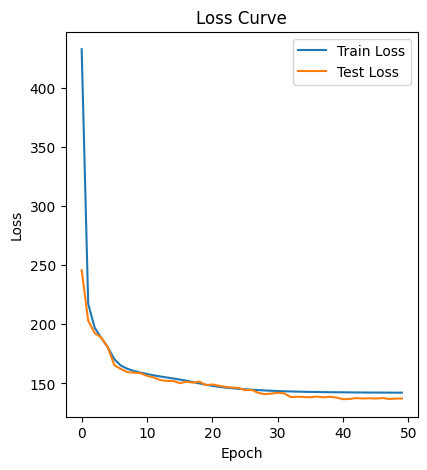

In [36]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_np/14748, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Reconstructing image

The reconstruction ability of your implementation will be evaluated. For images in the validation dataset, plot the reconstructed image from VAE and **add in the report**. 

For consistency, use the following code to visualize the reconstructed images.

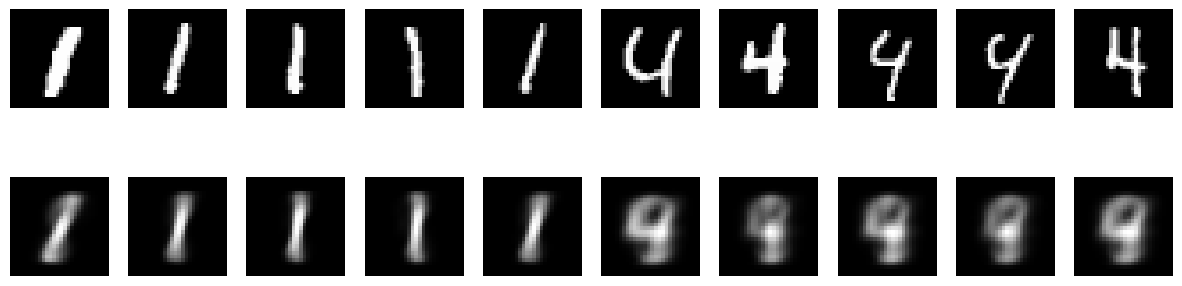

In [51]:
def show_reconstruction(model, val_loader, n=10):
    model.eval()
    data, labels = next(iter(val_loader))

    # Needs to be changed
    my_data = data.view(-1, 28*28)
    my_data = my_data.to(device)
    
    data = data.to(device)
    _, _, _, recon_data = model(my_data) # Needs to be changed
    
    fig, axes = plt.subplots(2, n, figsize=(15, 4))
    for i in range(n):
        # Original images
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(recon_data[i].cpu().view(28, 28).detach().numpy(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

n = 10
val_loader = DataLoader(test_dataset, batch_size = n)
show_reconstruction(vae, val_loader, n=n)

## Generating New Images

Note that the latent space of the VAE is normal distribution that allows us to sample latent vectors and pass it to the decoder to generate new images from the data distribution. In this part of the assignment, we will evaluate the VAE's generation capability by uniformly sampling from the latent space. Specifically, use the following code snippet to sample latent vectors, feed them into the VAE’s decoder, and generate new images. **Include these generated images in your report** to show your VAE's generative performance.

You can use the following code to generated images and plot in form of grid..

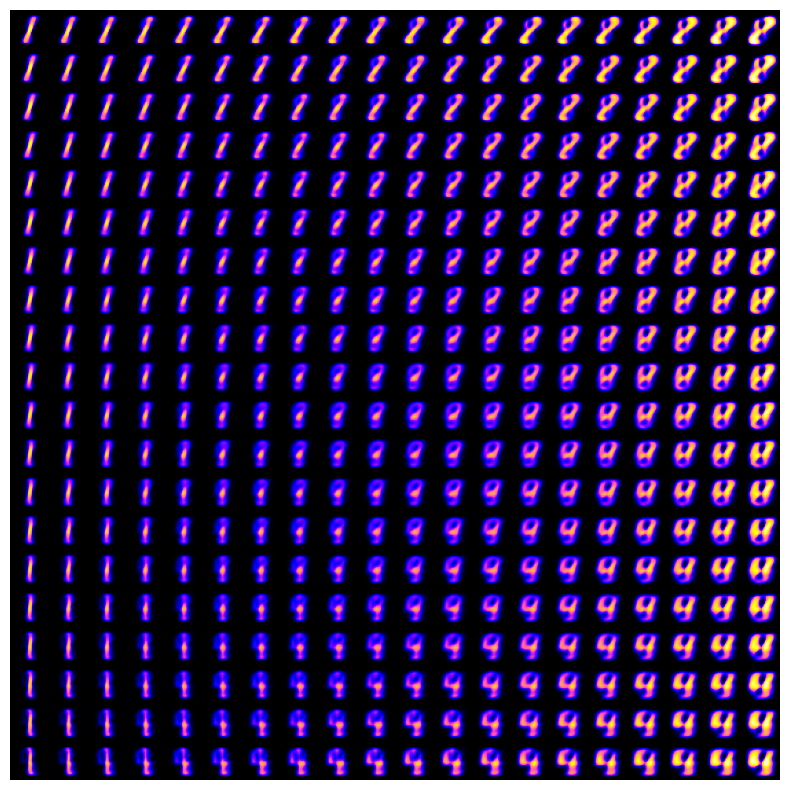

In [59]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_2d_manifold(vae, latent_dim=2, n=20, digit_size=28, device='cuda'):
    figure = np.zeros((digit_size * n, digit_size * n))

    # Generate a grid of values between 0.05 and 0.95 percentiles of a normal distribution
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    vae.eval()  # Set VAE to evaluation mode
    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = torch.tensor([[xi, yi]], device=device).float()

                # Pass z to VAE Decoder
                digit = vae.decoder(z_sample)
                # Write your code here
                digit = digit.view(digit_size, digit_size).cpu().numpy()

                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit


    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.axis('off')
    plt.show()

plot_2d_manifold(vae, latent_dim=2, n=20, digit_size=28, device='cuda')

## Visualizing Latent Space

To visualize the structure of the VAE's latent space, extract the latent vector for each image in the training dataset, then plot these vectors in a 2D scatter plot. Add this scatter plot to your report and observe the distribution. Look for distinct clustering patterns—ideally, you should see three clusters, each resembling a 2D normal distribution. Comment on whether the clusters are well-separated and follow the expected distribution, indicating the VAE has effectively organized the latent space for classification.

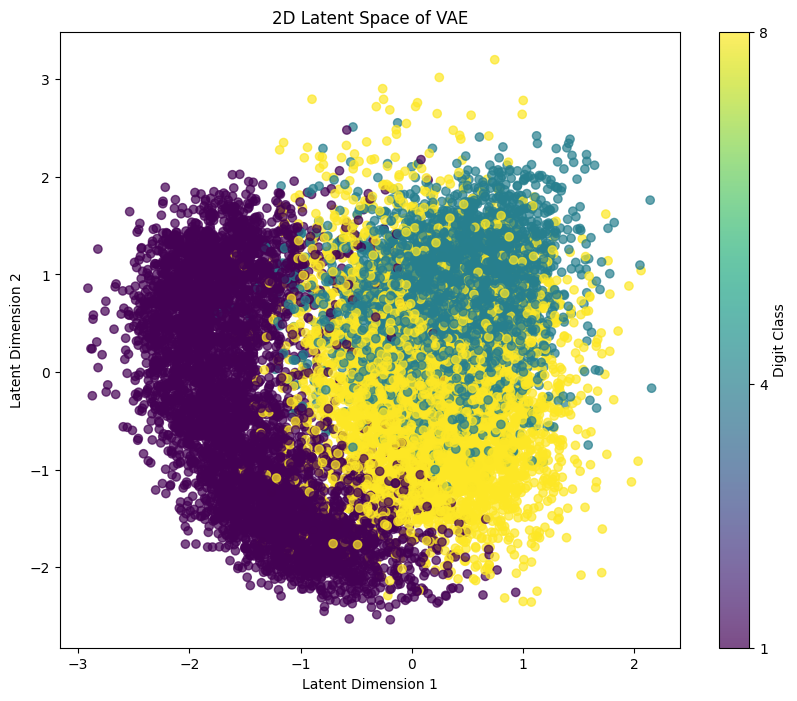

In [66]:
def visualize_latent_space(vae, dataloader, device='cuda'):
    vae.eval()  # Set VAE to evaluation mode
    
    all_latents = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            data = data.view(-1, 28*28)
            labels = labels.to(device)
            
            # Encode data to obtain latent mean (mu) and log variance (log_var)
            encoding = vae.encoder(data)
            mu = vae.z_mean(encoding)
            log_var = vae.z_log_var(encoding)
            
            # Sample latent vector z from the distribution (using reparameterization trick)
            z = vae.reparameterize(mu, log_var)
            
            # Append to lists
            all_latents.append(z.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all collected latent vectors and labels
    all_latents = torch.cat(all_latents).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Plot the 2D latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
    
    colorbar = plt.colorbar(scatter, ticks=[1, 4, 8])
    colorbar.set_label('Digit Class')
    colorbar.set_ticklabels(['1','4','8'])
    
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("2D Latent Space of VAE")
    plt.show()

# Example usage with DataLoader, assuming you have a DataLoader named 'train_loader'
visualize_latent_space(vae, train_loader, device='cuda')

## Visualizing GMM

To visualise the GMM model, plot each Gaussian distribution as an ellipse, with the center representing the mean and the shape reflecting the covariance. This visualisation will help assess whether the learned GMM effectively separates the clusters. Analyze the plot to determine if the clusters are distinct or if there is overlap that could indicate misclassification.